# TD3: Statistics, Unsupervised, and Supervised  Machine Learning on 3D shapes with Topological Data Analysis

In this practical session, we will use the various TDA tools presented in class in order to run data science tasks (inference, clustering, classification) on a data set of 3D shapes. As in the first practical session, we will use  [`Gudhi`](https://gudhi.inria.fr/) (see first practical session for installation instructions). The different sections of this notebook can be run independently (except Section 0 which is mandatory), so feel free to start with the project that sounds the more interesting to you :-)

Note also that if you choose to switch from a section to another, make sure to clear all variables first (and run Section 0 again) since some variable names are shared between sections.

In [1]:
import gudhi as gd
print(gd.__version__)

3.8.0a0


Other than that, you are free to use whatever other Python package you feel comfortable with :-) We make some suggestions below (these dependencies are also required to run our solutions to the exercises). 

In [2]:
import os
import sys

We will use three standard Python libraries: `NumPy`, `Scipy` and `Matplotlib`.

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In order to visualize 3D shapes, we will use [`meshplot`](https://skoch9.github.io/meshplot/tutorial/).

In [5]:
import meshplot as mp

When computing vectorizations and performing supervised machine learning and deep learning tasks, we will use various modules of [`Scikit-Learn`](https://scikit-learn.org/stable/index.html).  

In [6]:
import sklearn.preprocessing   as skp
import sklearn.neighbors       as skn
import sklearn.model_selection as skm
import sklearn.decomposition   as skd
import sklearn.manifold        as skf
import sklearn.pipeline        as skl
import sklearn.svm             as sks
import sklearn.ensemble        as ske

# Section 0: Data set manipulation

We are good to go! First things first, we have to download the data set. It can be obtained [here](https://people.cs.umass.edu/~kalo/papers/LabelMeshes/labeledDb.7z). Extract it, and save its path in the `dataset_path` variable.

In [7]:
dataset_path = './3dshapes/'

As you can see, the data set in split in several categories (`Airplane`, `Human`, `Teddy`, etc), each category having its own folder. Inside each folder, some 3D shapes (i.e., 3D triangulations) are provided in [`.off`](https://en.wikipedia.org/wiki/OFF_(file_format)) format, and face (i.e., triangle) labels are provided in text files (extension `.txt`). 

Every data science project begins by some preprocessing ;-) 

Write a function `off2numpy` that reads information from an `.off` file and store it in two `NumPy` arrays, called `vertices` (type float and shape number_of_vertices x 3---the 3D coordinates of the vertices) and `faces` (type integer and shape number_of_faces x 3---the IDs of the vertices that create faces). Write also a function `get_labels` that stores the face labels of a given 3D shape in a `NumPy` array (type string or integer and shape [number_of_faces].  

In [8]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [9]:
def get_labels(label_name, num_faces):
    L = np.empty([num_faces], dtype='|S100')
    with open(label_name, 'r') as S:
        info = S.readlines()
    labels, face_indices = info[0::2], info[1::2]
    for ilab, lab in enumerate(labels):
        indices = [int(f)-1 for f in face_indices[ilab].split(' ')[:-1]]
        L[  np.array(indices)  ] = lab[:-1]
    return L

You can now apply your code and use `meshplot` to visualize a given 3D shape, say `61.off` in `Airplane`, and the labels on its faces.

In [10]:
vertices, faces = off2numpy(dataset_path + 'Airplane/61.off')
label_faces = get_labels(dataset_path + 'Airplane/61_labels.txt', len(faces))

In [11]:
mp.plot(vertices, faces, c=skp.LabelEncoder().fit_transform(label_faces))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0636740…

If `meshplot` does not work, we also provide a fix with `matplotlib` (it requires converting the face labels into point labels though).

In [12]:
def face2points(vals_faces, faces, num_vertices):
    vals_points = np.empty([num_vertices], dtype=type(vals_faces))
    for iface, face in enumerate(faces):
        vals_points[face] = vals_faces[iface]
    return vals_points

<IPython.core.display.Javascript object>


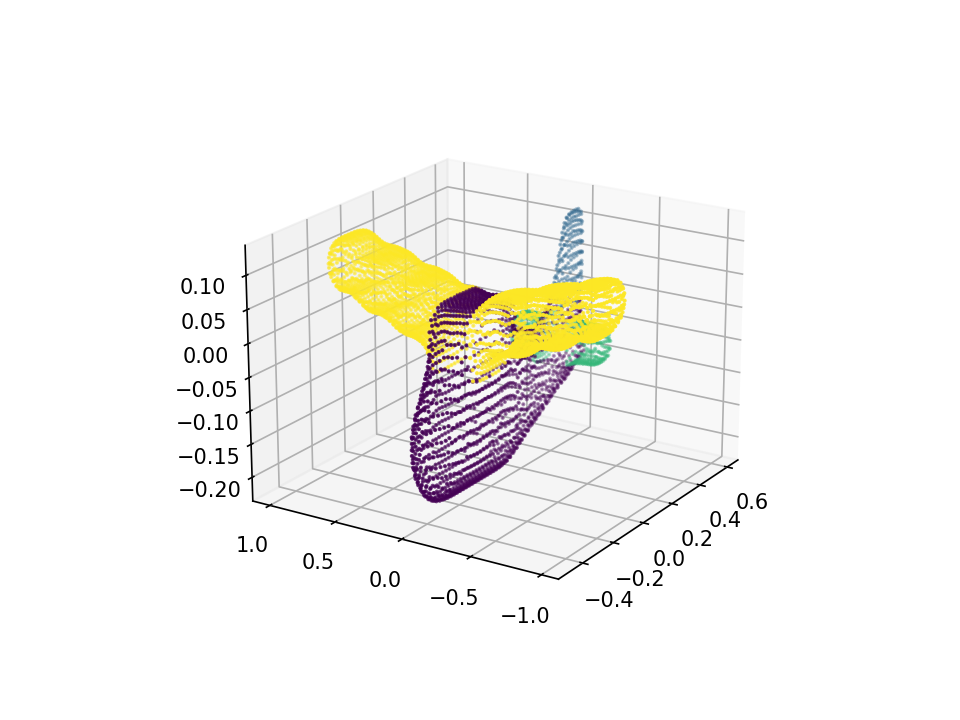

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(
    face2points(label_faces, faces, len(vertices))))
plt.show()

# Section 1: 3D shape statistics with persistence diagrams

In this section, our goal is to compute confidence regions associated to the persistence diagram of a given 3D shape. We will study such regions for both the persistence diagram, and one of its representation, the persistence landscape. 

Let's first pick a 3D shape. For instance, use `Hand/181.off` (or any other one you would like to try).

In [14]:
vertices, faces = off2numpy('3dshapes/Vase/361.off')

In [15]:
mp.plot(vertices, faces, c=vertices[:,1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0170675…

The first standard way of obtaining confidence regions for (geometric) persistence diagrams is through the stability theorem (see class):

$$\mathbb{P}(d_b(D_{\rm Rips}(X),D_{\rm Rips}(\hat X_n)) \geq \delta)\leq \mathbb{P}(d_H(X,\hat X_n)\geq \delta/2),$$
$$\mathbb{P}(d_b(D_{\rm Cech}(X),D_{\rm Cech}(\hat X_n)) \geq \delta)\leq \mathbb{P}(d_H(X,\hat X_n)\geq \delta),$$

where $d_H(\cdot,\cdot)$ is the Hausdorff distance, defined, for any two compact spaces $X,Y\subset \mathbb{R}^d$, as 

$$d_H(X,Y)={\rm min}\{{\rm max}_{x\in X}{\rm min}_{y\in Y}\|x-y\|, {\rm max}_{y\in Y}{\rm min}_{x\in X}\|y-x\|\}.$$

Hence, it suffices to estimate $\mathbb{P}(d_H(X,\hat X_n)\geq \delta)$ in order to derive confidence regions for persistence diagrams. There exists an upper bound for this probability when $\hat X_n$ is drawn from an $(a,b)$-standard probability measure, however this bound depends on $a$ and $b$. In the following, we will rather use the subsampling method, that allows to estimate the probability solely from subsampling $\hat X_n$ with $s(n) =o\left(\frac{n}{{\rm log}(n)}\right)$ points, and computing $d_H(\hat X_n, \hat X_{s(n)})$. The exact procedure is described in Section 4.1 in [this article](file:///user/mcarrier/home/Downloads/14-AOS1252.pdf).

Write a function `hausdorff_distance` that computes the Hausdorff distance between the vertices of our 3D shape and a subset of these vertices.

Now, write a function `hausdorff_interval` that computes this Hausdorff distance many times and uses the corresponding distribution of Hausdorff distances in order to output the bottleneck distance value associated to a given confidence level (by computing the quantile---corresponding to this confidence level---of the distribution).

Apply your code to obtain a bottleneck distance associated to, say, 90% confidence.

All right, now let's see which points of the persistence diagram are we going to label non-significant and discard. Compute the Rips and Alpha persistence diagrams of the points. 

Now, visualize the persistence diagrams with a band of size the previously computed bottleneck distance times 2 (for Alpha filtration) and 4 (for Rips filtration).

Are you discarding many points? If yes, this could be because the confidence region is computed only from the stability property of persistence diagrams: subsampling the Hausdorff distance can sometimes be quite conservative. It would be more efficient to bootstrap the persistence diagrams themselves---this is the approach advocated in Section 6 of [this article](https://www.jmlr.org/papers/volume18/15-484/15-484.pdf). However, this method was only proved for persistence diagrams obtained through the sublevel sets of kernel density estimators... But let's try it anyway! ;-)

Similarly than before, write `bottleneck_distance_bootstrap` and `bottleneck_interval` functions that compute the bottleneck distances between our current persistence diagram (in homology dimension 1) and the persistence diagrams of many bootstrap iterates.

Compute the bottleneck distance associated to a confidence level and visualize it.

Are you discarding less points in the persistence diagram now?

Another approach with more theoretical guarantees is to use the persistence landscapes associated to the persistence diagram. Indeed, valid confidence regions can be easily obtained using, e.g., algorithm 1 in [this article](https://geometrica.saclay.inria.fr/team/Fred.Chazal/papers/cflrw-scpls-14/cflrw-scpls-14.pdf). In the following, we will fix a subsample size $s(n)$, and estimate $\mathbb{E}[\Lambda_{s(n)}]$, where $\Lambda_{s(n)}$ is the landscape of a random subsample of size $s(n)$ (i.e., drawn from a probability measure $\mu$ such as, e.g., the empirical measure). 

Let's first make sure that we can compute landscapes ;-) Use `Gudhi` to compute and plot the first six persistence landscapes associated to the persistence diagram computed above in homology dimension 1. Landscapes (and other vectorizations) are implemented with the API of `Scikit-Learn` estimators, which means that you have to call the `fit_transform` method on a list of persistence diagrams in order to get their landscapes. 

Write a function `landscape_interval` that implements the landscape bootstrap procedure, that is, drawing many subsamples of size $s(n)$, computing their Alpha persistence diagrams and landscapes, computing the distribution of distances between each single landscape and their mean (multiplied by a random normal variable), and finally using the quantiles of this distribution in order to obtain confidence regions for the mean landscape.

Apply and visualize the confidence interval around the different landscapes.

The confidence regions are much better now!

Another interesting property of mean landscapes is their robustness to noise:

$$\|\mathbb{E}[\Lambda_{s(n)}^X]-\mathbb{E}[\Lambda_{s(n)}^Y]\|_\infty\leq 2 \cdot s(n) \cdot d_{GW}(\mu,\nu),$$

where $d_{GW}$ is the 1-Gromov-Wasserstein distance between probability measures. See Remark 6 in [this article](https://geometrica.saclay.inria.fr/team/Fred.Chazal/papers/cflmrw-smph-15/ICMLFinal.pdf). We will now confirm this by adding outlier noise to the 3D shape and looking at the resulting mean landscape.  

Create a noisy version of `vertices` with some outlier noise.

Let's first compare the persistence landscapes of the two sets of vertices. Compute and visualize these landscapes on the same plot.

As one can see, they are quite different. By contrast, computing the mean landscape with subsamples is much more robust, as we will now see.

Compute the mean persistence landscape of the noisy point cloud, and visualize it next to the mean persistence landscape of the clean point cloud.

Now, these landscapes looks much more in agreement!

# Section 2: 3D shape classification with persistence diagrams

In this section, our goal is to use persistence diagrams for classifying and segmenting 3D shapes with supervised machine learning. 

Let's start with classification. We will compute persistence diagrams for all shapes in different categories, and train a classifier from `Scikit-Learn` to predict the category from the persistence diagrams. Since `Gudhi` requires simplex trees from the persistence diagram computations, write a `get_simplex_tree_from_faces` function that builds a simplex tree from the faces of a given 3D shape triangulation.

Now, compute all the persistence diagrams (in homology dimension 0) associated to the sublevel sets of the third coordinate from a few categories, and retrieve their corresponding labels.

As discussed in class, it is not very convenient to use persistence diagrams directly for machine learning purposes (except for a few methods such as $K$-nearest neighbors). What we need is to define a vectorization, that is, a map $\Phi:\mathcal{D}\rightarrow\mathcal{H}$ sending persistence diagrams into a Hilbert space, or equivalently,  a symmetric kernel function $k:\mathcal{D}\times \mathcal{D} \rightarrow \mathbb{R}$ such that $k(D,D')=\langle \Phi(D),\Phi(D')\rangle$. Fortunately, there are already a bunch of such maps and kernels in `Gudhi` :-)

In the following we will compute and visualize the most popular kernels on some persistence diagrams. Pick first a specific persistence diagram and use `DiagramSelector` to remove its points with infinite coordinates.

Now, let's see what `Gudhi` has to offer to vectorize persistence diagrams with `Scikit-Learn` estimator-like classes, that is, with classes that have `fit`, `transform`, and `fit_transform` methods, see [this article](https://arxiv.org/pdf/1309.0238.pdf) for more details. For each vectorization mentioned below, we recommend you to play with its parameters and infer their influence on the ouput in order to get some intuition. 

The first vectorization method that was introduced historically is the persistence landscape. A persistence landscape is basically obtained by rotating the persistence diagram by $-\pi/4$
(so that the diagonal becomes the $x$-axis), and then putting tent functions on each point. The $k$th landscape is then defined as the $k$th largest value among all these tent functions. It is eventually turned into a vector by evaluating it on a bunch of uniformly sampled points on the $x$-axis.

Compute and visualize the first landscape of the persistence diagram for various parameters.

A variation, called the silhouette, takes a weighted average of these tent functions instead. Here, we weight each tent function by the distance of the corresponding point to the diagonal.

The second method is the persistence image. A persistence image is obtained by rotating by $-\pi/4$, centering Gaussian functions on all diagram points (usually weighted by a parameter function, such as, e.g., the squared distance to the diagonal) and summing all these Gaussians. This gives a 2D function, that is pixelized into an image.

`Gudhi` also has a variety of metrics and kernels, which sometimes perform better than explicit vectorizations such as the ones described above. Pick another persistence diagram, and get familiar with the bottleneck and the Wasserstein distances between them. Note that you can call them in different ways in `Gudhi`, there are `bottleneck_distance` and `wasserstein_distance` functions for instance, but there are also wrappers of these functions into estimator classes `BottleneckDistance` and `WassersteinDistance` (with `fit` and `transform` methods). These classes are especially useful when doing model selection with `Scikit-Learn`, see below.

`Gudhi` also allows to use standard kernels such as, among others, the persistence scale space kernel, persistence Fisher kernel, sliced Wasserstein kernel, etc. Try computing the kernel values for your pair of diagrams.

Before trying to classify the persistence diagrams, let's do a quick dimension reduction with PCA. Apply `PCA`, `KernelPCA` or `MDS` (available in `Scikit-Learn`) on the explicit maps (landscapes, images, etc), kernel matrices (Fisher, sliced Wasserstein, etc) and distance matrices (bottleneck, Wasserstein, etc) respectively.

Is there any method that looks better in separating the categories, at least by eye?

All right, let's try classification now! Shuffle the data, and create a random 80/20 train/test split.

Here is the best thing about having estimator-like classes: they can be integrated flawlessly in a `Pipeline` of `Scikit-Learn` for model selection and cross-validation! A `Pipeline` is itself an estimator, and is initialized as with a list of estimators. It will just sequentially apply the `fit_transform` methods of the estimators in the list.

Define a `Pipeline` with four estimators: one for selecting the finite persistence diagram points, one for scaling (or not) the persistence diagrams (with `DiagramScaler`), one for vectorizing persistence diagrams, and one for performing the final prediction. See the [documentation](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).

Now, define a grid of parameter that will be used in cross-validation.

Define and train the model.

Check the parameters that were chosen during model selection, and evaluate your model on the test set.

How good is your score? How would you improve it? You can also try to use PersLay to learn which representation to use, see this [tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-perslay-visu.ipynb).